In [2]:
%pip install scienceplots

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Selected L (discrete):   [50, 637, 2000]
Selected L (continuous): [50, 637, 2000]


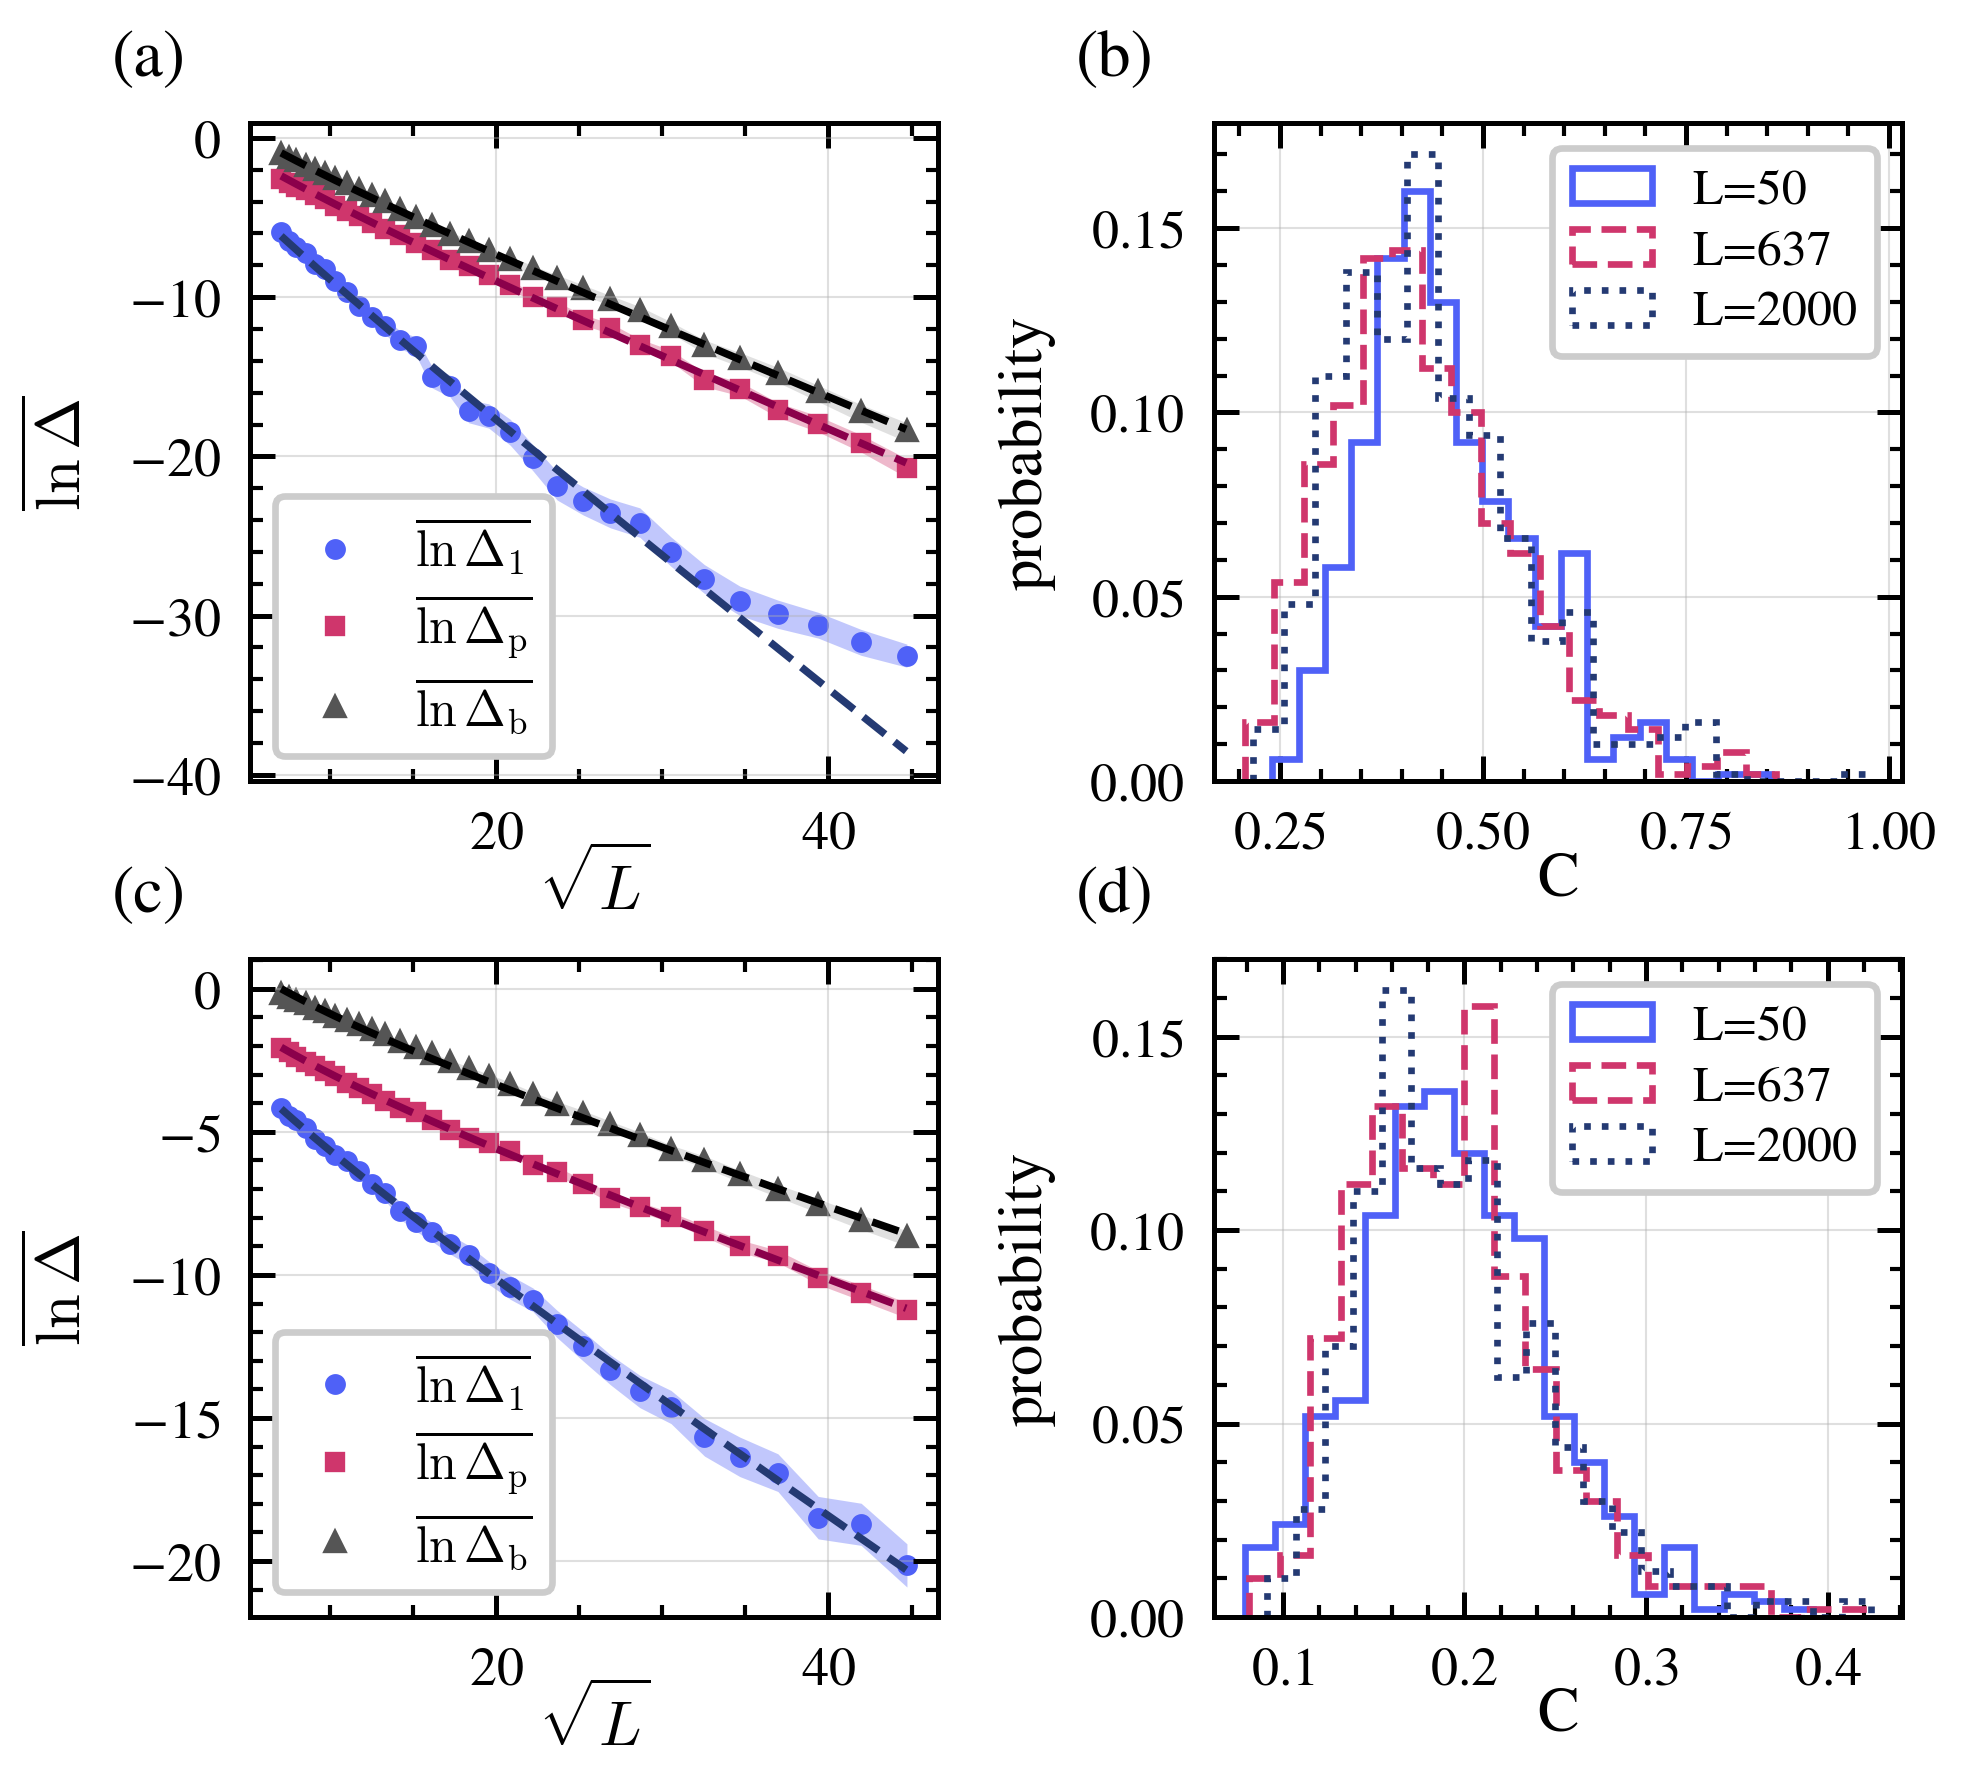

In [13]:
#!/usr/bin/env python3
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots  # pip install SciencePlots

# ---------- file paths ----------
CONT_PATH = "data/free_Fermion_result_tdl.csv"
DISC_PATH = "data/free_Fermion_result_discrete_tdl.csv"
SAVE_PATH = "figures/fig1.pdf"  # set to None to skip saving

# patterns for Yukai's random upper-bound data (actually Delta_b)
UB_CONT_PATTERN = "data_ub/fig1/data_continuous_random_*.txt"
UB_DISC_PATTERN = "data_ub/fig1/data_discrete_random_*.txt"

# ---------- custom colors ----------
COL_LIGHT = "#4F61F7"  # blue (Delta_1 points/std band)
COL_MED   = "#CF366C"  # magenta-rose (Delta_p points/std band)

# separate colors for fit lines
COL_FIT1  = "#243A73"  # darker blue for fit Delta_1
COL_FIT2  = "#8B004B"  # darker magenta / wine for fit Delta_p

# distinct red for Delta_b
COL_UB     = "#555555"  # dark gray for Delta_b line + band
COL_UB_FIT = "#000000"  # black for Delta_b fit

HIST_COLS = [COL_LIGHT, COL_MED, COL_FIT1]

# ---------- figure size for single-column RevTeX ----------
FIG_WIDTH_INCH  = 3.4
FIG_HEIGHT_INCH = 3.0

# ---------- z-value for 99% CI (two-sided) ----------
Z_99 = 2.5758293035489004  # ≈ 2.576


# ---------- helpers ----------
def load_df(path):
    """Load CSV and keep TDL columns with positive L."""
    df = pd.read_csv(path)
    for c in ["L", "eps1", "eps2", "tdl_eps1", "tdl_eps2"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["L", "tdl_eps1", "tdl_eps2"])
    df = df[df["L"] > 0].copy()
    df["L"] = df["L"].astype(int)
    return df


def load_ub_df(pattern):
    """
    Load Yukai's random data from a set of 2-line text files.
    Files contain Delta_b = eps1 + eps2_ub:
      first line: L values (space-separated)
      second line: Delta_b values (space-separated)
    """
    rows = []
    for path in sorted(glob.glob(pattern)):
        with open(path, "r") as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        if len(lines) < 2:
            continue
        Ls   = [int(v)   for v in lines[0].split()]
        vals = [float(v) for v in lines[1].split()]
        if len(Ls) != len(vals):
            print(f"[warn] skipping {path}: len(L) != len(Delta_b)")
            continue
        for L, e in zip(Ls, vals):
            if e > 0 and np.isfinite(e):
                rows.append((int(L), float(e)))
    if not rows:
        return pd.DataFrame(columns=["L", "Delta_b"])
    df = pd.DataFrame(rows, columns=["L", "Delta_b"])
    df["L"] = df["L"].astype(int)
    return df


def perL_logmean_std(df, col):
    """
    Compute per-L log-space mean and 99% confidence interval
    for a positive quantity.

    We assume ln(q) is approximately normal for each fixed L.

    Returns DataFrame with columns: L, x = sqrt(L), mu, lo, hi, n
      mu = mean[ln q]
      lo = mu - z_99 * SEM[ln q]
      hi = mu + z_99 * SEM[ln q]
    where SEM = sigma / sqrt(n), sigma is the sample standard deviation.
    """
    rows = []
    for L, g in df.groupby("L"):
        vals = g[col].to_numpy()
        vals = vals[(vals > 0) & np.isfinite(vals)]
        if vals.size == 0:
            continue
        logs = np.log(vals)
        mu = float(np.mean(logs))
        n = logs.size
        if n > 1:
            sigma = float(np.std(logs, ddof=1))  # sample std of ln q
            sem = sigma / np.sqrt(n)            # standard error of ln q
            half_width = Z_99 * sem             # 99% CI half-width
            lo, hi = mu - half_width, mu + half_width
        else:
            lo = hi = mu
        rows.append((int(L), float(np.sqrt(L)), mu, lo, hi, int(n)))
    return pd.DataFrame(
        rows, columns=["L", "x", "mu", "lo", "hi", "n"]
    ).sort_values("x")


def fit_log_with_lnL(L, q, log_threshold=-28.0):
    """
    Fit ln q = ln A - c sqrt(L) - 0.5 ln L.
    Use only L whose geometric mean of q is > exp(log_threshold).
    """
    L = np.asarray(L)
    q = np.asarray(q)
    mask_base = (q > 0) & np.isfinite(q) & np.isfinite(L)
    L_all = L[mask_base]
    q_all = q[mask_base]

    if q_all.size == 0:
        raise ValueError("No valid data points for fit.")

    valid_L = []
    for Lv in np.unique(L_all):
        vals = q_all[L_all == Lv]
        vals = vals[(vals > 0) & np.isfinite(vals)]
        if vals.size == 0:
            continue
        mu = float(np.mean(np.log(vals)))
        if mu > log_threshold:
            valid_L.append(Lv)

    valid_L = np.array(valid_L)
    if valid_L.size == 0:
        raise ValueError("All per-L geometric means are below threshold for fit.")

    mask = mask_base & np.isin(L, valid_L)
    X = np.sqrt(L[mask])
    y = np.log(q[mask]) + 0.5 * np.log(L[mask])

    if X.size < 2:
        raise ValueError("Not enough data points after applying geometric-mean threshold.")

    m, b = np.polyfit(X, y, deg=1)
    c = -float(m)
    A = float(np.exp(b))
    return A, c


def pick_L_targets(df, target_list):
    """Pick nearest available L values to a target list."""
    uniqL = np.sort(df["L"].unique())
    chosen = []
    for t in target_list:
        if t in uniqL:
            chosen.append(int(t))
        else:
            idx = np.argmin(np.abs(uniqL - t))
            chosen.append(int(uniqL[idx]))
    # de-duplicate while preserving order
    seen, out = set(), []
    for x in chosen:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out


def compute_C_series(df, L_value, A_Dp, col_name="tdl_Delta_p"):
    """
    C variable from Delta_p:
      C = [ln A_Dp - 0.5 ln L - ln(Delta_p)] / sqrt(L)
    """
    sub = df[df["L"] == L_value].copy()
    if sub.empty:
        return np.array([])
    q = sub[col_name].to_numpy()
    q = q[(q > 0) & np.isfinite(q)]
    if q.size == 0:
        return np.array([])
    L = float(L_value)
    C = (np.log(A_Dp) - 0.5 * np.log(L) - np.log(q)) / np.sqrt(L)
    C = C[np.isfinite(C)]
    return C


def freedman_diaconis_bins(x):
    """Return number of histogram bins using Freedman–Diaconis rule."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return 10
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        return min(30, max(5, int(np.sqrt(n))))
    h = 2 * iqr / (n ** (1 / 3))
    if h <= 0:
        return min(30, max(5, int(np.sqrt(n))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return min(60, max(10, bins))


def xfit_from_df(df):
    """Return x grid (sqrt L) for fit lines."""
    Lmin = int(np.min(df["L"].values))
    Lmax = int(np.max(df["L"].values))
    xlo = np.sqrt(Lmin) * 1.001
    xhi = np.sqrt(Lmax) * 0.999
    return np.linspace(xlo, xhi, 400)


# ---------- load data ----------
df_cont = load_df(CONT_PATH)
df_disc = load_df(DISC_PATH)

# define Delta_1 and Delta_p
df_disc["tdl_Delta_1"] = df_disc["tdl_eps1"]
df_disc["tdl_Delta_p"] = df_disc["tdl_eps1"] + df_disc["tdl_eps2"]

df_cont["tdl_Delta_1"] = df_cont["tdl_eps1"]
df_cont["tdl_Delta_p"] = df_cont["tdl_eps1"] + df_cont["tdl_eps2"]

# ---------- load Delta_b data (Yukai) ----------
df_cont_ub = load_ub_df(UB_CONT_PATTERN)
df_disc_ub = load_ub_df(UB_DISC_PATTERN)

# ---------- fits (TDL Delta_1, Delta_p, Delta_b) ----------
A_D1_disc, c_D1_disc = fit_log_with_lnL(df_disc["L"].values, df_disc["tdl_Delta_1"].values)
A_D1_cont, c_D1_cont = fit_log_with_lnL(df_cont["L"].values, df_cont["tdl_Delta_1"].values)

A_Dp_disc, c_Dp_disc = fit_log_with_lnL(df_disc["L"].values, df_disc["tdl_Delta_p"].values)
A_Dp_cont, c_Dp_cont = fit_log_with_lnL(df_cont["L"].values, df_cont["tdl_Delta_p"].values)

A_Db_disc = c_Db_disc = None
A_Db_cont = c_Db_cont = None

if not df_disc_ub.empty:
    A_Db_disc, c_Db_disc = fit_log_with_lnL(df_disc_ub["L"].values, df_disc_ub["Delta_b"].values)

if not df_cont_ub.empty:
    A_Db_cont, c_Db_cont = fit_log_with_lnL(df_cont_ub["L"].values, df_cont_ub["Delta_b"].values)

# ---------- x grid for fit lines ----------
xfit_disc = xfit_from_df(df_disc)
xfit_cont = xfit_from_df(df_cont)

yfit_disc_D1 = np.log(A_D1_disc) - c_D1_disc * xfit_disc - np.log(xfit_disc)
yfit_disc_Dp = np.log(A_Dp_disc) - c_Dp_disc * xfit_disc - np.log(xfit_disc)
yfit_cont_D1 = np.log(A_D1_cont) - c_D1_cont * xfit_cont - np.log(xfit_cont)
yfit_cont_Dp = np.log(A_Dp_cont) - c_Dp_cont * xfit_cont - np.log(xfit_cont)

yfit_disc_Db = None
yfit_cont_Db = None
if A_Db_disc is not None:
    yfit_disc_Db = np.log(A_Db_disc) - c_Db_disc * xfit_disc - np.log(xfit_disc)
if A_Db_cont is not None:
    yfit_cont_Db = np.log(A_Db_cont) - c_Db_cont * xfit_cont - np.log(xfit_cont)

# ---------- choose L targets for C histograms ----------
L_targets_disc = pick_L_targets(df_disc, [int(df_disc["L"].min()), 637, int(df_disc["L"].max())])
L_targets_cont = pick_L_targets(df_cont, [int(df_cont["L"].min()), 637, int(df_cont["L"].max())])
print("Selected L (discrete):  ", L_targets_disc)
print("Selected L (continuous):", L_targets_cont)

# ---------- per-L log-space mean ± 99% CI ----------
disc_D1 = perL_logmean_std(df_disc, "tdl_Delta_1")
disc_Dp = perL_logmean_std(df_disc, "tdl_Delta_p")
cont_D1 = perL_logmean_std(df_cont, "tdl_Delta_1")
cont_Dp = perL_logmean_std(df_cont, "tdl_Delta_p")

disc_Db = perL_logmean_std(df_disc_ub, "Delta_b") if not df_disc_ub.empty else pd.DataFrame()
cont_Db = perL_logmean_std(df_cont_ub, "Delta_b") if not df_cont_ub.empty else pd.DataFrame()

# ---------- plotting (single-column, global style) ----------
with plt.style.context(['science', 'ieee', 'no-latex']):

    # global styling: fonts and line widths
    plt.rcParams.update({
        # fonts (smaller than RevTeX 10pt body text)
        "font.size": 7.5,
        "axes.labelsize": 7.5,
        "axes.titlesize": 7.5,
        "xtick.labelsize": 6.5,
        "ytick.labelsize": 6.5,
        "legend.fontsize": 6,

        # line widths
        "axes.linewidth": 0.6,
        "lines.linewidth": 0.9,
        "lines.markersize": 1.5,
        "patch.linewidth": 0.8,

        # ticks
        "xtick.major.width": 0.6,
        "ytick.major.width": 0.6,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,

        # grid
        "grid.linewidth": 0.25,
        "grid.alpha": 0.4,

        # legend frame
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.framealpha": 1.0,
    })

    fig, axs = plt.subplots(2, 2, figsize=(FIG_WIDTH_INCH, FIG_HEIGHT_INCH))

    # fairly tight layout for 2x2 panels in a square single column
    plt.subplots_adjust(
        left=0.18, right=0.99,
        bottom=0.16, top=0.99,
        wspace=0.4, hspace=0.27
    )

    # ===== (a) CONTINUOUS: ln(Delta) vs sqrt(L) =====
    ax = axs[0, 0]

    # shaded 99% CI band
    ax.fill_between(cont_D1["x"], cont_D1["lo"], cont_D1["hi"],
                    color=COL_LIGHT, alpha=0.35, linewidth=0, zorder=0)
    ax.fill_between(cont_Dp["x"], cont_Dp["lo"], cont_Dp["hi"],
                    color=COL_MED,   alpha=0.35, linewidth=0, zorder=0)
    if not cont_Db.empty:
        ax.fill_between(cont_Db["x"], cont_Db["lo"], cont_Db["hi"],
                        color=COL_UB, alpha=0.18, linewidth=0, zorder=0)

    # mean of ln Delta
    ax.plot(cont_D1["x"], cont_D1["mu"], marker="o", color=COL_LIGHT,
            label=r"$\overline{\ln \Delta_1}$", zorder=1, linestyle="None")
    ax.plot(cont_Dp["x"], cont_Dp["mu"], marker="s", color=COL_MED,
            label=r"$\overline{\ln \Delta_{\mathrm{p}}}$", zorder=1, linestyle="None")
    if not cont_Db.empty:
        ax.plot(cont_Db["x"], cont_Db["mu"], marker="^", color=COL_UB,
                label=r"$\overline{\ln \Delta_{\mathrm{b}}}$", zorder=1, linestyle="None")

    # all fits use linestyle="--"
    ax.plot(xfit_cont, yfit_cont_D1, "--", color=COL_FIT1)
    ax.plot(xfit_cont, yfit_cont_Dp, "--", color=COL_FIT2)
    if (not cont_Db.empty) and (yfit_cont_Db is not None):
        ax.plot(xfit_cont, yfit_cont_Db, "--", color=COL_UB_FIT)

    ax.set_xlabel(r"$\sqrt{L}$", labelpad=-1)
    ax.set_ylabel(r"$\overline{\ln \Delta}$")
    ax.grid(True)
    ax.legend(loc="best", handlelength=1.6, labelspacing=0.3)
    ax.text(-0.20, 1.05, "(a)", transform=ax.transAxes,
            fontsize=8.0, va="bottom", ha="left")

    # ===== (b) CONTINUOUS: histogram of C (from Delta_p) =====
    ax = axs[0, 1]
    for col, Lval in zip(HIST_COLS, L_targets_cont):
        C = compute_C_series(df_cont, Lval, A_Dp_cont, col_name="tdl_Delta_p")
        if C.size == 0:
            continue
        bins = freedman_diaconis_bins(C)
        weights = np.ones_like(C) / C.size
        ax.hist(C, bins=bins, density=False, weights=weights,
                histtype="step", color=col, label=f"L={Lval}")

    ax.set_xlabel("C", labelpad=-1)
    ax.set_ylabel(r"probability")
    ax.grid(True)
    ax.legend(loc="best", handlelength=1.6, labelspacing=0.3)
    ax.text(-0.20, 1.05, "(b)", transform=ax.transAxes,
            fontsize=8.0, va="bottom", ha="left")

    # ===== (c) DISCRETE: ln(Delta) vs sqrt(L) =====
    ax = axs[1, 0]

    ax.fill_between(disc_D1["x"], disc_D1["lo"], disc_D1["hi"],
                    color=COL_LIGHT, alpha=0.35, linewidth=0, zorder=0)
    ax.fill_between(disc_Dp["x"], disc_Dp["lo"], disc_Dp["hi"],
                    color=COL_MED,   alpha=0.35, linewidth=0, zorder=0)
    if not disc_Db.empty:
        ax.fill_between(disc_Db["x"], disc_Db["lo"], disc_Db["hi"],
                        color=COL_UB, alpha=0.18, linewidth=0, zorder=0)

    ax.plot(disc_D1["x"], disc_D1["mu"], marker="o", color=COL_LIGHT,
            label=r"$\overline{\ln \Delta_1}$", zorder=1, linestyle="None")
    ax.plot(disc_Dp["x"], disc_Dp["mu"], marker="s", color=COL_MED,
            label=r"$\overline{\ln \Delta_{\mathrm{p}}}$", zorder=1, linestyle="None")
    if not disc_Db.empty:
        ax.plot(disc_Db["x"], disc_Db["mu"], marker="^", color=COL_UB,
                label=r"$\overline{\ln \Delta_{\mathrm{b}}}$", zorder=1, linestyle="None")

    # all fits use linestyle="--"
    ax.plot(xfit_disc, yfit_disc_D1, "--", color=COL_FIT1)
    ax.plot(xfit_disc, yfit_disc_Dp, "--", color=COL_FIT2)
    if (not disc_Db.empty) and (yfit_disc_Db is not None):
        ax.plot(xfit_disc, yfit_disc_Db, "--", color=COL_UB_FIT)

    ax.set_xlabel(r"$\sqrt{L}$", labelpad=-1)
    ax.set_ylabel(r"$\overline{\ln \Delta}$")
    ax.grid(True)
    ax.legend(loc="best", handlelength=1.6, labelspacing=0.3)
    ax.text(-0.20, 1.05, "(c)", transform=ax.transAxes,
            fontsize=8.0, va="bottom", ha="left")

    # ===== (d) DISCRETE: histogram of C (from Delta_p) =====
    ax = axs[1, 1]
    for col, Lval in zip(HIST_COLS, L_targets_disc):
        C = compute_C_series(df_disc, Lval, A_Dp_disc, col_name="tdl_Delta_p")
        if C.size == 0:
            continue
        bins = freedman_diaconis_bins(C)
        weights = np.ones_like(C) / C.size
        ax.hist(C, bins=bins, density=False, weights=weights,
                histtype="step", color=col, label=f"L={Lval}")

    ax.set_xlabel("C", labelpad=-1)
    ax.set_ylabel(r"probability")
    ax.grid(True)
    ax.legend(loc="best", handlelength=1.6, labelspacing=0.3)
    ax.text(-0.20, 1.05, "(d)", transform=ax.transAxes,
            fontsize=8.0, va="bottom", ha="left")

    if SAVE_PATH:
        fig.savefig(SAVE_PATH, bbox_inches="tight")
    plt.show()
